In [46]:
import numpy as np
import xarray as xr
import netCDF4
import datetime as dt
import os
from scipy.interpolate import Rbf
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.cm as cm
import pyinterp
mesh = pyinterp.RTree()




In [51]:
## Create regular grid
#Read the solution (one specific filename) or solutions (based on the directory)
#if you are using specific filename
filename="SSM_v43_2018_0001.nc"
#!ncrename -v siglev,siglev_matrix SSM_v43_2018_0001.nc
#!ncrename -v time,time_vector SSM_v43_2018_0001.nc
ssm_solution=xr.open_dataset(filename, decode_times=False, drop_variables=['siglev','siglay'])
min_lat = ssm_solution.lat.min().values
max_lat = ssm_solution.lat.max().values
min_lon = ssm_solution.lon.min().values
max_lon = ssm_solution.lon.max().values
STEP = 0.01
reg_lat = np.arange(min_lon, max_lon + STEP, STEP)
reg_lon = np.arange(min_lat, max_lat + STEP, STEP)
## New grids
mx, my = np.meshgrid(reg_lat, reg_lon, indexing='ij')


ncrename Command line options cheatsheet (full details at http://nco.sf.net/nco.html#ncrename):
ncrename [-a ...] [--bfr byt] [-D nco_dbg_lvl] [-d ...] [-g ...] [--glb ...] [-h] [--hdr_pad nbr] [--hpss] [-l path] [-O] [-o out.nc] [-p path] [-R] [-r] [-v ...] in.nc [[out.nc]]

-a, --attribute old_att,new_att Attribute's old and new names
    --bfr_sz, buffer_size sz	Buffer size to open files with
-D, --dbg_lvl, debug-level lvl	Debug-level is lvl
-d, --dmn, dimension old_dim,new_dim Dimension's old and new names
-g, --grp, group	old_grp,new_grp Group's old and new names
    --glb_att_add nm=val	Global attribute to add
-h, --hst, history	Do not append to "history" global attribute
    --hdr_pad, header_pad	Pad output header with nbr bytes
    --hpss, hpss_try	Search for unfound files on HPSS with 'hsi get ...'
-l, --lcl, local path	Local storage path for remotely-retrieved files
-O, --ovr, overwrite	Overwrite existing output file, if any
-o, --output, fl_out out.nc	Output file name (or us

ncrename Command line options cheatsheet (full details at http://nco.sf.net/nco.html#ncrename):
ncrename [-a ...] [--bfr byt] [-D nco_dbg_lvl] [-d ...] [-g ...] [--glb ...] [-h] [--hdr_pad nbr] [--hpss] [-l path] [-O] [-o out.nc] [-p path] [-R] [-r] [-v ...] in.nc [[out.nc]]

-a, --attribute old_att,new_att Attribute's old and new names
    --bfr_sz, buffer_size sz	Buffer size to open files with
-D, --dbg_lvl, debug-level lvl	Debug-level is lvl
-d, --dmn, dimension old_dim,new_dim Dimension's old and new names
-g, --grp, group	old_grp,new_grp Group's old and new names
    --glb_att_add nm=val	Global attribute to add
-h, --hst, history	Do not append to "history" global attribute
    --hdr_pad, header_pad	Pad output header with nbr bytes
    --hpss, hpss_try	Search for unfound files on HPSS with 'hsi get ...'
-l, --lcl, local path	Local storage path for remotely-retrieved files
-O, --ovr, overwrite	Overwrite existing output file, if any
-o, --output, fl_out out.nc	Output file name (or us

In [49]:
#Read the solution (one specific filename) or solutions (based on the directory)
#if you are using specific filename
original_lat = ssm_solution.lat.values
original_lon = ssm_solution.lon.values
original_sigglev= ssm_solution.siglev.values
original_time=ssm_solution.siglev.values
time=2                        
level=8
org_variable=ssm_solution.temp[time][level].values


In [50]:
mesh.packing(np.vstack((original_lon, original_lat)).T, org_variable)

idw, neighbors = mesh.inverse_distance_weighting(np.vstack((mx.ravel(), my.ravel())).T,
    within=True,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbors
    num_threads=0)
idw = idw.reshape(mx.shape)
## Krigging is probably the bet for interpolations
## information can be found here :https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.RTree.universal_kriging.html
kriging, neighbors = mesh.universal_kriging(
    np.vstack((mx.ravel(), my.ravel())).T,
    within=True,  # Extrapolation is forbidden
    k=11,
    covariance='matern_12',
    alpha=100_000,
    num_threads=0)
kriging = kriging.reshape(mx.shape)



Text(0.5, 1.0, 'RBF interpolation 2')

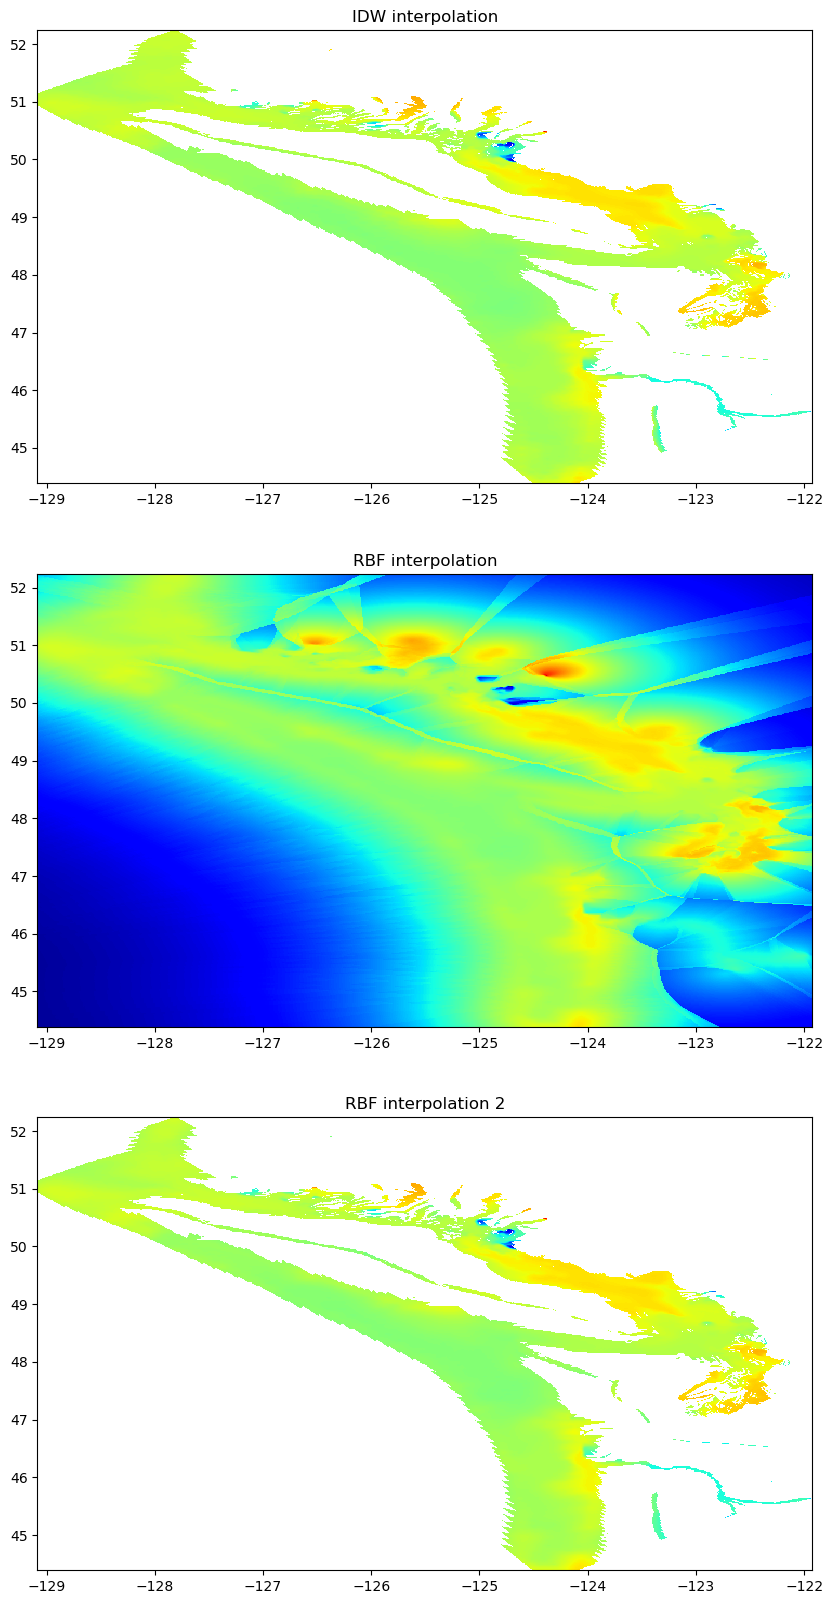

In [14]:
vmin = 0
vmax = 15
fig = matplotlib.pyplot.figure(figsize=(10, 20))
ax1 = fig.add_subplot(211)
pcm = ax1.pcolormesh(mx,
                     my,
                     idw,
                     cmap='jet',
                     shading='auto',
                     vmin=vmin,
                     vmax=vmax)
ax1.set_title('IDW interpolation')
ax2 = fig.add_subplot(212)
pcm = ax2.pcolormesh(mx,
                     my,
                     kriging,
                     cmap='jet',
                     shading='auto',
                     vmin=vmin,
                     vmax=vmax)
ax2.set_title('RBF interpolation')


In [43]:


original_sigmlev = ssm_solution.siglev_matrix.values
print(original_sigmlev)

[[-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [-0.03162277 -0.03162277 -0.03162277 ... -0.03162277 -0.03162277
  -0.03162277]
 [-0.08944271 -0.08944271 -0.08944271 ... -0.08944271 -0.08944271
  -0.08944271]
 ...
 [-0.7155418  -0.7155418  -0.7155418  ... -0.7155418  -0.7155418
  -0.7155418 ]
 [-0.85381496 -0.85381496 -0.85381496 ... -0.85381496 -0.85381496
  -0.85381496]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
